In [1]:
import pandas as pd
import numpy as np
import dataset

C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing of Input Data

In [3]:
df_original = pd.read_csv('data/reviews.csv')

In [18]:
df = df_original.copy()
df['y'] = df.Label.replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})
df.tail()

,Id,Review,Label,y
107013,107013,Trendy topic with talks from expertises in the...,4,2
107014,107014,"Wonderful! Simple and clear language, good ins...",5,2
107015,107015,an interesting and fun course. thanks. dr quincy,5,2
107016,107016,"very broad perspective, up to date information...",4,2
107017,107017,An informative course on the social and financ...,4,2


In [19]:
df['y'].value_counts()

2    97227
1     5071
0     4720
Name: y, dtype: int64

Looks like we have a highly imbalanced data

In [20]:
# text preprocessing part
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

stemmer = WordNetLemmatizer()
porter = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

def preprocessingText(corpus, lowercase=True, rmPunctuation=True, rpURL=True, rpNumber=True, stemming=True):
    """Input is assumed to be vector of documents"""
    documents = []
    for text in corpus:
        document = text
        
        # HYPERPARAMETER
        # Converting to Lowercase
        if lowercase:
            document = document.lower()

        # replace URL
        if rpURL:
            # replace URL
            document = re.sub(r'http\S+', 'url', document, flags=re.MULTILINE)

        # replace numbers
        if rpNumber:
            document = re.sub("\d+", "number", document)

        # remove all special characters including punctuation
        if rmPunctuation:
            # only keep word
            document = re.sub(r'\W', ' ', document)
            # remove all single characters
            document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
            # Remove single characters from the start
            document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # OTHER PREPROCESSING METHODS
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        
        # removing stopwords
        document = document.split()
        document = [word for word in document if word not in STOPWORDS]

        if stemming:
            # Lemmatization
            document = [stemmer.lemmatize(word) for word in document]
            # stemming
            document = [porter.stem(word) for word in document]

        document = ' '.join(document)
        documents.append(document)
    return documents

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jordan.yew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jordan.yew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jordan.yew\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [21]:
df['text'] = preprocessingText(df.Review)
print(df.tail().text)

107013    trendi topic talk expertis field cover area in...
107014    wonder simpl clear languag good instructor gre...
107015                   interest fun cours thank dr quinci
107016    broad perspect date inform use link video good...
107017    inform cours social financi implic due zika we...
Name: text, dtype: object


In [25]:
# let's make the data balanced first
np.random.seed(8307)
positive_indices = df[df.y == 2].index
random_indices = np.random.choice(positive_indices, 5071, replace=False)
positive_sample = df.loc[random_indices]
positive_sample

,Id,Review,Label,y,text
67348,67348,The course is very interesting. In the beginni...,5,2,cours interest begin seem bit heavi neurosci i...
38747,38747,Considering that internet and media regulation...,5,2,consid internet medium regul hot topic polici ...
17832,17832,Quite useful for introducing Data Science. I w...,5,2,quit use introduc data scienc enrol data scien...
65168,65168,Great course!This course is perfect for beginn...,5,2,great cours cours perfect beginn interest lear...
46273,46273,Very useful and effective,4,2,use effect
...,...,...,...,...,...
83880,83880,It's a very good course. I learn more about th...,5,2,good cours learn lesson thank teacher lesson
30829,30829,This is a really good start.,5,2,realli good start
8588,8588,good for basic knowledge in cancer biology.,5,2,good basic knowledg cancer biolog
91826,91826,Fantastic course as always from the legendary ...,5,2,fantast cours alway legendari dr chuck


In [26]:
# combine reduced ham with spam
df2 = pd.concat([positive_sample, df[df['y'] != 2]], verify_integrity=True)
df2['y'].value_counts()

2    5071
1    5071
0    4720
Name: y, dtype: int64

In [27]:
# now that our data is balanced, let's split into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['text'], df2['y'], 
                                                    test_size=0.1, 
                                                    stratify=df2['y'],
                                                    random_state=8307)
print('value counts of y_train is :', y_train.value_counts())

value counts of y_train is : 2    4564
1    4563
0    4248
Name: y, dtype: int64


# Different Approaches of Sentiment Analysis
- tfidf with Naive Bayes
- tdidf with Other ML
- word2vec with normal neural network
- rnn
- cnn
- bert transformer

### (1) Naive Bayes alone

In [57]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize

# This is how the Naive Bayes classifier expects the input
def create_word_features(words):
    useful_words = [word for word in word_tokenize(words) if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

# X_train, X_test, y_train, y_test
train_NB = []
test_NB = []

for x, y in zip(X_train.tolist(), y_train.tolist()):
    train_NB.append((create_word_features(x), y))

for x, y in zip(X_test.tolist(), y_test.tolist()):
    test_NB.append((create_word_features(x), y))

classifier = NaiveBayesClassifier.train(train_NB)
accuracy = nltk.classify.util.accuracy(classifier, test_NB)
print(accuracy * 100)

49.96637525218561


### (2) tf-idf with knn classifier

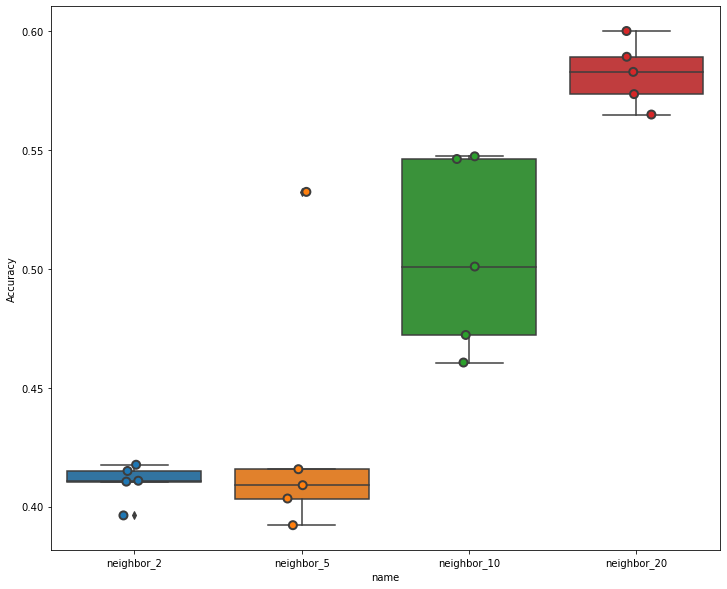

Final Accuracy: 0.5722932078009415


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# perform text processing before fitting
tfid = TfidfVectorizer()
tfid.fit(X_train)

X_train_tf = tfid.transform(X_train)
X_test_tf = tfid.transform(X_test)

neighbors = [2, 5, 10, 20]
knn_names = ['neighbor_{}'.format(n) for n in neighbors]
models = [KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski') for n in neighbors]

scores = []

for name, model in zip(knn_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), 
                                   y=y_train, cv=5, scoring='accuracy')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "Accuracy"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='Accuracy', data=cv_df)
sns.stripplot(x='name', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

final_knn = KNeighborsClassifier(n_neighbors=20, p=2, metric='minkowski')
final_knn.fit(X_train_tf.toarray(), y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_knn.predict(X_test_tf.toarray())))

Seems better than merely naive bayes

### (3) N-gram with logistic regression

C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

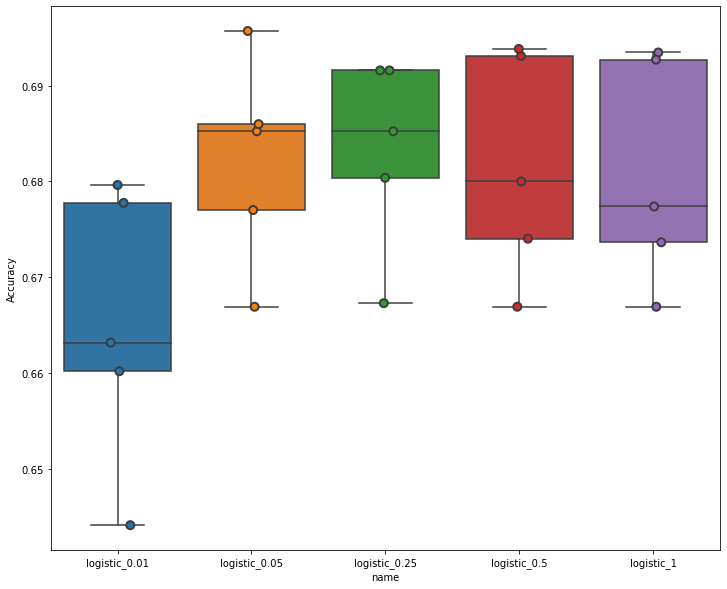

Final Accuracy: 0.6872898453261601


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(X_train)
X_train_ngram = ngram_vectorizer.transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

Cs = [0.01, 0.05, 0.25, 0.5, 1]
lr_names = ['logistic_{}'.format(c) for c in Cs]
models = [LogisticRegression(C=c) for c in Cs]

scores = []

for name, model in zip(lr_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_ngram, 
                                   y=y_train, cv=5, scoring='accuracy')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "Accuracy"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='Accuracy', data=cv_df)
sns.stripplot(x='name', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()
    
final_ngram = LogisticRegression(C=0.25)
final_ngram.fit(X_train_ngram, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_ngram.predict(X_test_ngram)))

Better than the previous two algorithms

### (4) word2vec with normal neural network

### (5) RNN & CNN

### (6) BERT Transformer